In [1]:
%cd ../..

c:\Users\abdul\Desktop\TUM\thesis\thesis


In [2]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from matplotlib import patches, pyplot as plt
import json

from src.inference.utils import load_model, transform_image

def load_tiger_image(image_id: int, path: str):
    with open(os.path.join(path, "tiger-coco.json"), 'r') as f:
        annotations = json.load(f)
    image_name = os.path.basename(annotations["images"][image_id]["file_name"])
    image = np.array(Image.open(os.path.join(path, "images", image_name)))
    bboxes = [  # bounding boxes for lymphocytes and plasma cells
        item for item in annotations["annotations"] 
        if item["image_id"] is image_id
    ]
    return image, bboxes

In [3]:
# load tiger data
image, bboxes = load_tiger_image(16, os.path.join("..", "tiger_fork", "tiger data"))
for bbox in bboxes:
    bbox["bbox"][0] -= image.shape[1] - 128
    bbox["bbox"][1] -= image.shape[0] - 128
image = image[-128:, -128:, :]

# load released models
models = [
    load_model(os.path.join("weights", model), out_channels=1, out_activation=None)
    for model in os.listdir("weights")
    if "det" in model
]

# inference 
model_input = transform_image(image)
segmentation = sum([model.predict_on_batch(model_input)[0, :, :, 0] for model in models]) / 3

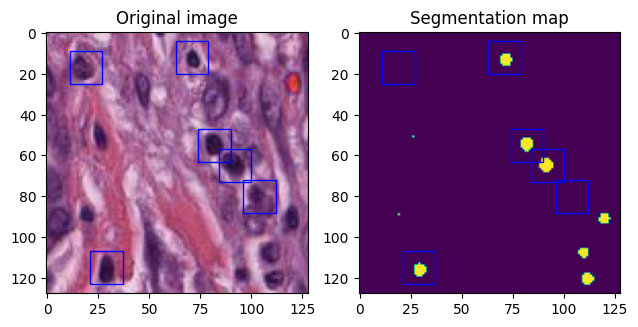

In [4]:
# display inference results

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(image)
axes[0].set_title("Original image")
axes[1].imshow(segmentation > 0.3)
axes[1].set_title("Segmentation map")
for ax in axes:
    for bbox in bboxes:
        x, y, w, h = bbox["bbox"]
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='b', facecolor='none'))
plt.tight_layout()
plt.show()